# Reconocedor de emociones

Para el siguiente trabajo se utilizó un dataset de imágenes digitalizadas de personas, para cada una de las cuales se identificó el rostro y se estimó la ubicación de 68 coordenadas (x, y) que mapean los puntos faciales. Estos landmarks fueron luego utilizados como entradas para entrenar una red neuronal con el propósito de poder predecir qué emoción representa cada rostro detectado.

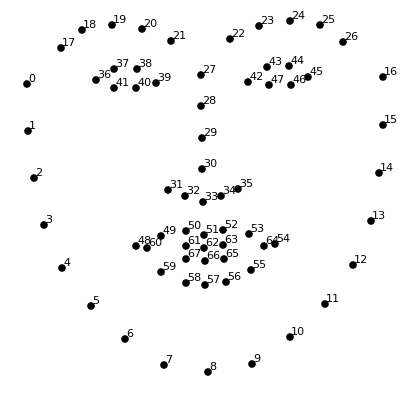

Dataset utilizado: https://www.kaggle.com/shawon10/ckplus

## Preparación del entorno y los datos

Se importa *numpy* para el manejo de los datos, *glob* para generar una lista de archivos que coinciden con un patron dado, *cv2* para la lectura de imágenes, *random* para aleatoriamente mezclar la lista de archivos y *phantom*, una librería de procesamiento forense de imágenes, que dispone de funciones para detectar rostros, extraer los 68 landmarks y normalizar los datos. También se importa tanto las capas como el modelo de keras para la definición del modelo.

In [52]:
import numpy as np
import glob
import cv2
import random
import phantom.faces as phf
import phantom.utils as phu
from keras import layers
from keras import models

In [69]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'] #Lista con las emociones
num_emotions = 8 #variable global que contiene la cantidad de emociones en la lista 
data = [] #variable global donde de almacenan los datos

La función *get_files* genera una lista de archivos asociados a una determinada emocion y toma el 80% de esos archivos que para entrenar y el 20% restante para predecir.

In [70]:
def get_files(emotion):
    """
    Lee archivo asociado a una determinda emocion y 
    duelve las imagenes para entrenar (80%) y predecir (20%)
    """
    
    files = glob.glob(f".\\{emotion}\\*")
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #toma el %80 del principio del archivo para training
    prediction = files[-int(len(files)*0.2):] #toma el 20% del final del archivo para predicciones
    
    return training, prediction

La función *get_landmarks* detecta el rostro en una determinada imagen, luego estima la ubicación de 68 landmarks y finalmente devuelve estos landamarks, los datos que alimentan la red neuronal, normalizados.

In [71]:
def get_landmarks(image):
    data = []
    locations = phf.detect(image) #Devuelve una lista de tuplas (left,top,right,bottom) con la ubicacion de cada cara hallada en la imagen
    
    if not locations:
        return None #Si no detecta caras devuelvo la lista vacia
    
    list_landmarks =  phf.landmark(image, locations=locations) #Devuelve lista de objetos 'phantom.faces.Shape', cada uno de los cuales describe la posición y puntos de referencia de cada rostro
    data = phf.normalize_landmark(list_landmarks[0]) #normaliza --> rango [-1,1]
    
    flat = []
    for (x, y) in data:
        flat.extend((x, y))
    flat = np.array(flat)
    
    return flat

La función *make_sets* devuelve listas con los datos y etiquetas tanto para el entrenamiento como para la predicción.

In [72]:
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    

    for emotion in emotions:
        print(f" working on {emotion}")
        training, prediction = get_files(emotion)

        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            data = get_landmarks(image)
            if data is None:
                print("no face detected on this one")
            else:
                training_data.append(data) #append image array to training data list
                training_labels.append(emotions.index(emotion))
                
        for item in prediction:
            image = cv2.imread(item) #open image
            data = get_landmarks(image)
            if data is None:
                print("no face detected on this one")
            else:
                prediction_data.append(data) #append image array to prediction data list
                prediction_labels.append(emotions.index(emotion))
                
    return training_data, training_labels, prediction_data, prediction_labels

In [89]:
training_data, training_labels, prediction_data, prediction_labels = make_sets()

 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
no face detected on this one
 working on neutral
 working on sadness
 working on surprise


In [90]:
#One-hot encoding is the representation of categorical variables as binary vectors.
from keras.utils import to_categorical

training_labels = to_categorical(training_labels)
prediction_labels = to_categorical(prediction_labels)

In [91]:
training_labels.shape
#prediction_lables.shape

(1066, 8)

In [92]:
type(training_labels)

numpy.ndarray

In [93]:
np.array(training_data).shape

(1066, 136)

## Definición del modelo 1

Se crea un modelo secuencial con capas densas para procesar los landmarks obtenidos.

In [94]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(136,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(num_emotions, activation='softmax')) 
#usar 'softmax' significa que la red generará una distribución de probabilidad sobre las emociones: 
#para cada muestra de entrada, la red producirá un vector de salida num_emotions dimensional,
#donde la salida [i] es la probabilidad de que la muestra pertenece a la emocion i.

In [95]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                2192      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 136       
Total params: 2,600
Trainable params: 2,600
Non-trainable params: 0
_________________________________________________________________
None


### Configurando el modelo para enternarlo

In [96]:
model.compile(loss='categorical_crossentropy',#the quantity to minimize during training, 'categorical_crossentropy' measures the distance between two probability distributions
              optimizer='rmsprop', #specifies the exact way in which the gradient of the loss will to update parameters
              metrics=['accuracy'])

In [97]:
history = model.fit(np.array(training_data),
                    np.array(training_labels),
                    epochs=150,
                    batch_size=512,
                    validation_data=(np.array(prediction_data), np.array(prediction_labels)))

Train on 1066 samples, validate on 264 samples
Epoch 1/150
1066/1066 [==============================] - 0s 117us/step - loss: 2.1333 - accuracy: 0.1388 - val_loss: 2.0478 - val_accuracy: 0.1402
Epoch 2/150
1066/1066 [==============================] - 0s 15us/step - loss: 2.0311 - accuracy: 0.1388 - val_loss: 1.9967 - val_accuracy: 0.1402
Epoch 3/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.9863 - accuracy: 0.1398 - val_loss: 1.9684 - val_accuracy: 0.1402
Epoch 4/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.9656 - accuracy: 0.1379 - val_loss: 1.9599 - val_accuracy: 0.2159
Epoch 5/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.9592 - accuracy: 0.1942 - val_loss: 1.9519 - val_accuracy: 0.1212
Epoch 6/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.9496 - accuracy: 0.1426 - val_loss: 1.9440 - val_accuracy: 0.1515
Epoch 7/150
1066/1066 [==============================] - 0s 15us/step - loss

1066/1066 [==============================] - 0s 0us/step - loss: 1.7742 - accuracy: 0.4522 - val_loss: 1.7677 - val_accuracy: 0.4621
Epoch 57/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.7686 - accuracy: 0.4578 - val_loss: 1.7646 - val_accuracy: 0.4659
Epoch 58/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.7652 - accuracy: 0.4568 - val_loss: 1.7651 - val_accuracy: 0.4091
Epoch 59/150
1066/1066 [==============================] - 0s 29us/step - loss: 1.7622 - accuracy: 0.4540 - val_loss: 1.7717 - val_accuracy: 0.4394
Epoch 60/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.7658 - accuracy: 0.4296 - val_loss: 1.7621 - val_accuracy: 0.4545
Epoch 61/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.7605 - accuracy: 0.4578 - val_loss: 1.7547 - val_accuracy: 0.4356
Epoch 62/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.7539 - accuracy: 0.4428 - val_loss: 1.7553 - val_ac

1066/1066 [==============================] - 0s 15us/step - loss: 1.5356 - accuracy: 0.5028 - val_loss: 1.5380 - val_accuracy: 0.4962
Epoch 112/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.5361 - accuracy: 0.4972 - val_loss: 1.5199 - val_accuracy: 0.5152
Epoch 113/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.5189 - accuracy: 0.5047 - val_loss: 1.5400 - val_accuracy: 0.4962
Epoch 114/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.5293 - accuracy: 0.4962 - val_loss: 1.5272 - val_accuracy: 0.5114
Epoch 115/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.5193 - accuracy: 0.5113 - val_loss: 1.5230 - val_accuracy: 0.5152
Epoch 116/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.5124 - accuracy: 0.5075 - val_loss: 1.5285 - val_accuracy: 0.5038
Epoch 117/150
1066/1066 [==============================] - 0s 15us/step - loss: 1.5171 - accuracy: 0.5159 - val_loss: 1.5216 -

### Evaluación del modelo

Definimos una función que nos permita graficar los parámetros del entrenamiento.

In [112]:
import matplotlib.pyplot as plt

def draw_history(history):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)
    plt.figure(1, figsize=(16, 14))
    plt.clf()
    
    # primer gráfico
    plt.subplot(221)
    plt.plot(epochs, h["loss"], "mo", label="Error del entrenamiento")
    plt.plot(epochs, h["val_loss"], "m", label="Error de validación")
    plt.xlabel("Épocas")
    plt.ylabel("Error")
    plt.legend()
    
    # segundo gráfico
    plt.subplot(222)
    plt.plot(epochs, h["accuracy"], "co", label="Precisión del entrenamiento")
    plt.plot(epochs, h["val_accuracy"], "c", label="Precisión de validación")
    plt.xlabel("Épocas")
    plt.ylabel("Precisión")
    plt.legend()
    
    # ahora mostramos todo junto
    #plt.show()

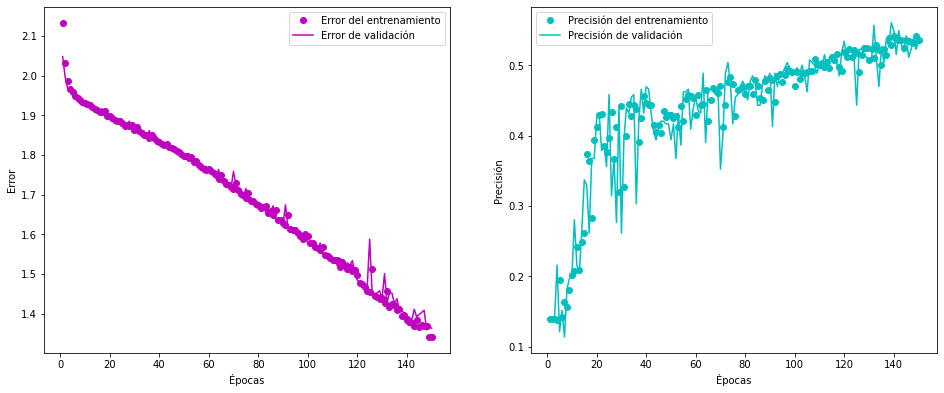

In [113]:
draw_history(history)

Definimos una funcion que nos permita visualizar la imagen y el procentaje asignado a cada una de las emociones dadas.

In [114]:
def predictEmotion(img):
    
    land = get_landmarks(img)#obtengo los landmarks
    phu.imshow(img) #imprimo la imagen
    results = model.predict(np.array([land]))

    i=0
    for result in np.nditer(results):
        print(f"{result} of {emotions[i]}")
        if i<(num_emotions - 1): #sino se pasa de rango
            i=i+1
              

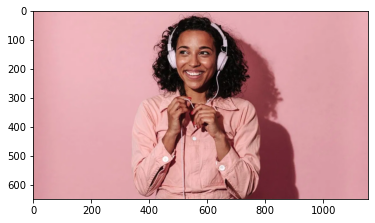

0.06757260859012604 of anger
0.012225151062011719 of contempt
0.22965113818645477 of disgust
0.05558184161782265 of fear
0.5500127673149109 of happiness
0.011828136630356312 of neutral
0.052336663007736206 of sadness
0.020791659131646156 of surprise


In [115]:
img = cv2.imread("test.jpg")
predictEmotion(img)

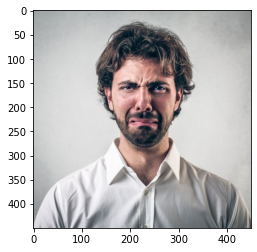

0.09593029320240021 of anger
0.004671350121498108 of contempt
0.6801644563674927 of disgust
0.01686726324260235 of fear
0.09322517365217209 of happiness
0.03124718926846981 of neutral
0.07642214000225067 of sadness
0.0014721362385898829 of surprise


In [117]:
img = cv2.imread("test2.jpg")
predictEmotion(img)

## Definición del modelo 2